# active inference model of agency task (basic)

### prerequisites

In [79]:
# !pip install inferactively-pymdp
import os
import sys
import pathlib
import numpy as np 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pymdp

from pymdp import utils 
from pymdp.utils import obj_array
from pymdp import maths
from pymdp.agent import Agent

In [80]:
# defining functions to plot beliefs about conditions and action_states
def plot_beliefs_conditions(Qs, title=""):
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='black', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.xticks(np.arange(5), ['human_positive', 'human_negative', 'comp_positive', 'comp_negative', 'zero'])
    plt.xticks(rotation=60)
    plt.title(title)
    plt.show()
    
def plot_beliefs_actions_states(Qs, title=""):
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='black', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.xticks(np.arange(4), ['humanAction_compAction', 'humanAction_compNoAction',
                              'humanNoAction_compAction', 'humanNoAction_compNoAction'])
    plt.xticks(rotation=60)
    plt.title(title)
    plt.show()

### specifying the states and observations

In [81]:
# state factors dictionary
## first state factor is the non-controllable state factor, which are the experimental conditions. human_positive means the human has positive (excitatory) control
## second state factor is the actions made
states = {'conditions' :['human_positive', 'human_negative', 
                         'comp_positive', 'comp_negative', 
                         'zero'], 
          'action_states' : ['humanAction_compAction', 'humanAction_compNoAction', 
                             'humanNoAction_compAction', 'humanNoAction_compNoAction']
         }

# observation modalities dictionary
## there needs to be an observational modality where there is proprioception
observations = {'outcome' : ['outcome_present', 'outcome_absent'],
                'action_observations' : states['action_states']
               }

# obtaining information about the state factors and observation modalities dictionaries
num_factors = len(num_states)
num_states = [len(states[key]) for key in states]
num_modalities = len(num_observations)
num_observations = [len(observations[key]) for key in observations]

# print(num_factors)
# print(num_states)
# print(num_modalities)
# print(num_observations)

### A matrices. likelihood matrices. p(o|s).
* no. of matrices = no. of observational modalities 
* no. of dimensions in each matrix = an additional dimension for each additional state factor
* no. of slices in the additional dimension(s) = no. of states in the corresponding state factor
* rows = observations 
* columns = states in the first state factor

In [82]:
# setting up empty (w zeros) A matrix using obj_array function w dimensions of number of states and number of observations
A = utils.obj_array_zeros([[no] + num_states for no in num_observations])

# likelihood matrix for outcome
A[0][:,:,0] = [[1, 0, 1, 0, .5], 
               [0, 1, 0, 1, .5]]

A[0][:,:,1] = [[1, 0, 0, 1, .5], 
               [0, 1, 1, 0, .5]]

A[0][:,:,2] = [[0, 1, 1, 0, .5], 
               [1, 0, 0, 1, .5]]

A[0][:,:,3] = [[0, 1, 0, 1, .5], 
               [1, 0, 1, 0, .5]]

# likelihood matrix for action_observations
for idx in range(num_states[1]):
    A[1][idx,:,idx] = np.ones(num_states[0])
    
# adding noise to each matrix by softmaxing it
A[0] = maths.softmax(2.0 * A[0])
A[1] = maths.softmax(2.0 * A[1])

### B matrices. transition matrices. p(s^t+1| s^t)
* no. of matrices = no. of state factors
* no. of dimensions in each matrix = an additional dimension for each additional state factor
* no. of slices in the additional dimension(s) = number of transitions you would like in each matrix - no cap.
* rows = states at t+1 
* columns = states at t

In [83]:
# specify how many transitions you would like in each matrix
num_transitions = [1, 1]

# setting up empty (w zeros) B matrix using obj_array function
B = utils.obj_array_zeros([[ns, ns, num_transitions[f]] for f, ns in enumerate(num_states)])

# transition matrix for conditions
for idx in range(num_states[0]):
    B[0][idx,idx,:] = 1

# transition matrix for action_states
for idx in range(num_transitions[1]):
    B[1][idx,idx,:] = 1
    
# # transition matrix for action_states - with num_transition[1] = 4
# for idx in range(num_transitions[1]):
#     B[1][idx,:,idx] = 1
    
# adding noise to each matrix by softmaxing it
B[0] = maths.softmax(2.0 * B[0])
B[1] = maths.softmax(2.0 * B[1])

### C matrices. preferences over observations. 
* no. of matrices = no. of observation modalities
* rows = observations 
* columns = timepoints in a trial

In [84]:
# setting up empty (w zeros) C matrix using obj_array function
C = utils.obj_array_zeros([no for no in num_observations])

# # preference to have an outcome present and avoid an outcome absent
# C[0] = np.array([10, -5])

### D vectors. prior over states

In [85]:
# setting up empty (w zeros) D vector using obj_array function
D = utils.obj_array(len(num_states))

# equal distribution as priors
D[0] = np.ones(5)/5.0
D[1] = np.ones(4)/4.0

### policies

In [86]:
# setting up the policies
policies = pymdp.control.construct_policies(num_states, num_transitions)

### running the model


time 1:
states: [('conditions', 'human_positive'), ('action_states', 'humanAction_compAction')]
observations: [('outcome', 'outcome_present'), ('action_observations', 'humanAction_compAction')]
[0. 0.]


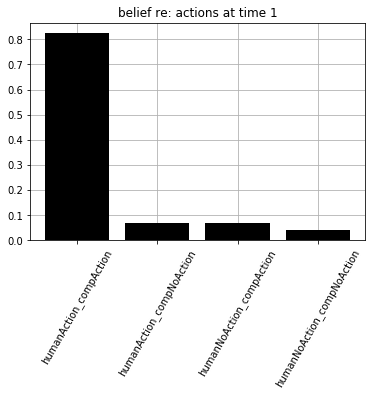

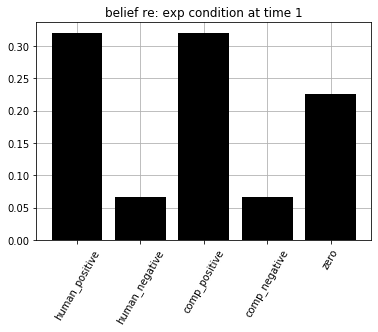


time 2:
states: [('conditions', 'human_positive'), ('action_states', 'humanAction_compAction')]
observations: [('outcome', 'outcome_present'), ('action_observations', 'humanAction_compAction')]
[0. 0.]


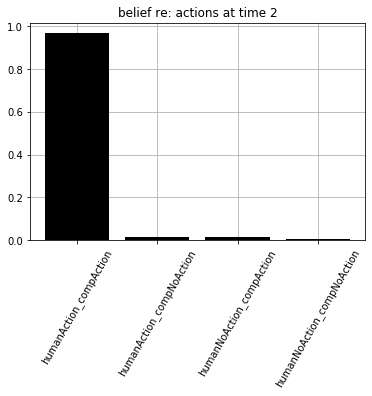

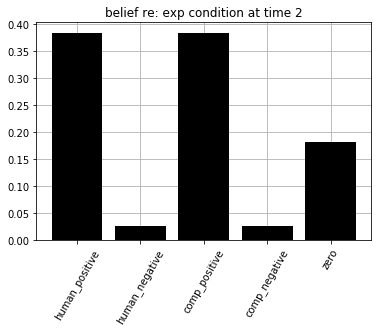


time 3:
states: [('conditions', 'human_positive'), ('action_states', 'humanNoAction_compNoAction')]
observations: [('outcome', 'outcome_present'), ('action_observations', 'humanAction_compNoAction')]
[0. 0.]


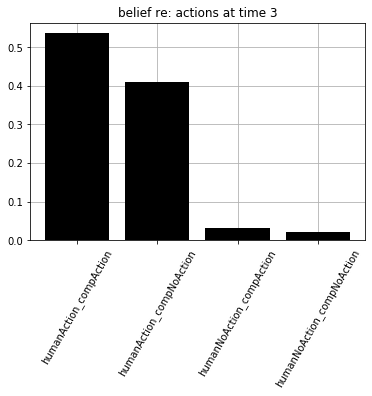

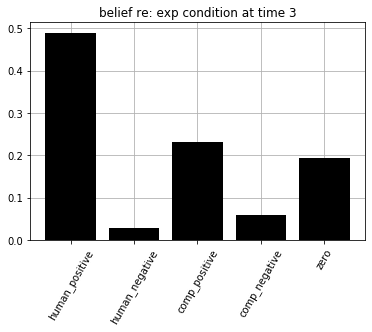


time 4:
states: [('conditions', 'human_positive'), ('action_states', 'humanAction_compNoAction')]
observations: [('outcome', 'outcome_absent'), ('action_observations', 'humanNoAction_compAction')]
[0. 0.]


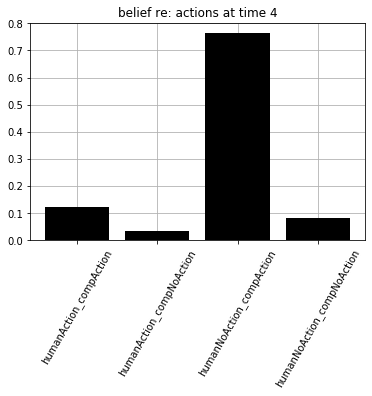

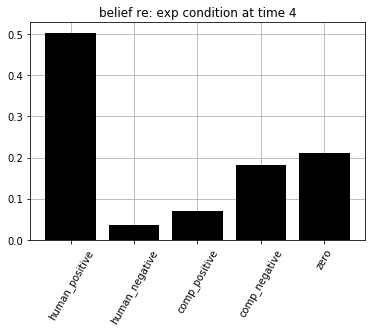


time 5:
states: [('conditions', 'human_positive'), ('action_states', 'humanAction_compAction')]
observations: [('outcome', 'outcome_present'), ('action_observations', 'humanAction_compNoAction')]
[0. 0.]


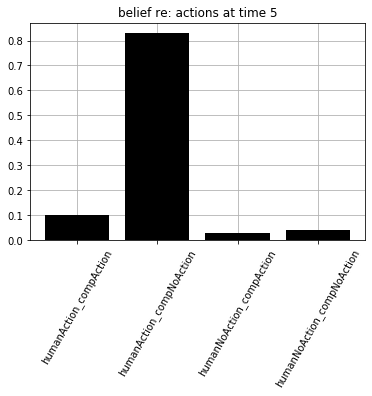

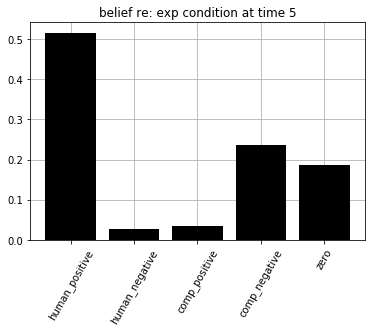


time 6:
states: [('conditions', 'human_positive'), ('action_states', 'humanAction_compNoAction')]
observations: [('outcome', 'outcome_absent'), ('action_observations', 'humanNoAction_compNoAction')]
[0. 0.]


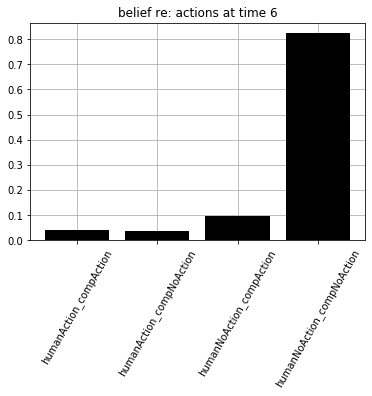

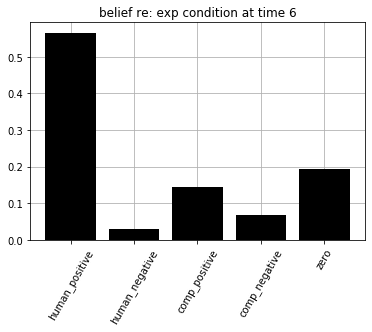


time 7:
states: [('conditions', 'zero'), ('action_states', 'humanAction_compNoAction')]
observations: [('outcome', 'outcome_absent'), ('action_observations', 'humanNoAction_compAction')]
[0. 0.]


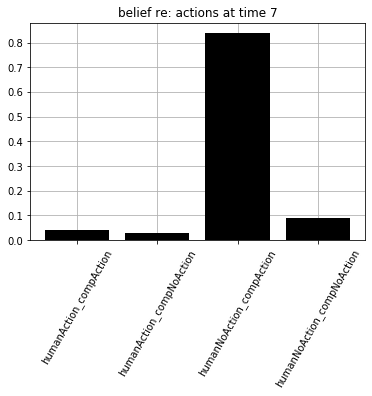

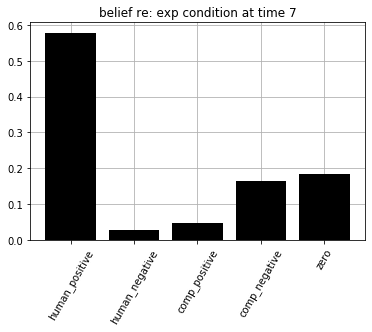


time 8:
states: [('conditions', 'zero'), ('action_states', 'humanAction_compNoAction')]
observations: [('outcome', 'outcome_present'), ('action_observations', 'humanAction_compAction')]
[0. 0.]


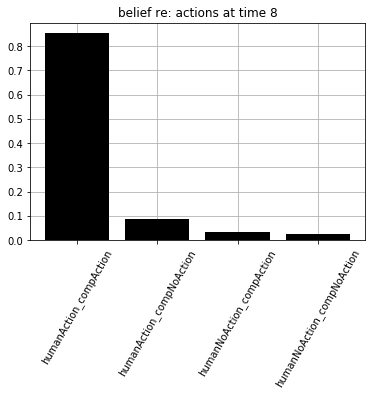

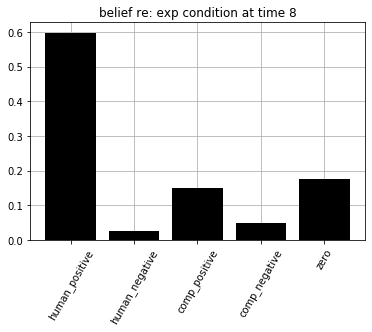

In [87]:
# setting up the agent
agent = Agent(A = A, B = B, C = C, policies = policies)
A_gp, B_gp, C_gp = copy.deepcopy(agent.A), copy.deepcopy(agent.B), copy.deepcopy(agent.C)

# number of timesteps in the simulation
T = 8 

# initial state
state = [0,0]

# observations they see at each timestep
o1 = [0,0] 
o2 = [0,0]
o3 = [0,1]
o4 = [1,2]
o5 = [0,1]
o6 = [1,3]
o7 = [1,2]
o8 = [0,0]
observation_cycle = [o1,o2,o3,o4,o5,o6,o7,o8]

# # second option
# o1 = [0,0] 
# o2 = [1,3]
# o3 = [1,2]
# o4 = [0,1]
# o5 = [1,2]
# o6 = [0,0]
# o7 = [1,3]
# o8 = [1,2]


# running the simulation
for t in range(len(observation_cycle)):

    observation = observation_cycle[t]

    print(f"\ntime {t+1}:")
    print(f"states: {[(list(states)[f], states[list(states)[f]][state[f]]) for f in range(len(states))]}")
    print(f"observations: {[(list(observations)[g], observations[list(observations)[g]][observation[g]]) for g in range(len(observations))]}")

    belief_state = agent.infer_states(observation)
    agent.infer_policies()
    action = agent.sample_action()
    print(action)
    
    for f, s in enumerate(state):
        state[f] = utils.sample(B_gp[f][:, s, int(action[f])])
    for g, _ in enumerate(observation):
        observation[g] = utils.sample(A_gp[g][:, state[0], state[1]]) 
        
    plot_beliefs_actions_states(agent.qs[1], "belief re: actions at time {}".format(t+1))
    plot_beliefs_conditions(agent.qs[0], "belief re: exp condition at time {}".format(t+1))

    
